In [1]:
import tifffile
import numpy as np


# In there upload the image you want split
# original_image = tifffile.imread(r'G:\Alexis_data\Project\FISH\input\Heart2_round3_DAPI_resliced-q1-z1_cp_masks.tif')

original_image = tifffile.imread(r'input\segmentation\Test_2DS_E3H5_Round1_DAPI_inference_merged_8bit-2.tif')

# Print image shape and data type
print(f"Image shape: {original_image.shape}")
print(f"Data type: {original_image.dtype}")

# Display basic statistics
print(f"Min value: {np.min(original_image)}")
print(f"Max value: {np.max(original_image)}")
print(f"Mean value: {np.mean(original_image)}")

Image shape: (2478, 1560)
Data type: uint8
Min value: 1
Max value: 255
Mean value: 32.80462350737775


In [2]:
def segment_2d_with_coordinates(data, partition_h=5, partition_w=6):
    """
    Segments 2D data and returns both segments and their coordinates

    Args:
        data: 2D array to be segmented
        partition_h: Number of horizontal partitions
        partition_w: Number of vertical partitions

    Returns:
        main_segments: list of regular-sized segments
        main_coordinates: list of (h_start, h_end, w_start, w_end)
        leftover_segments: list of leftover segments
        leftover_coordinates: list of coordinates for leftover segments
    """
    height, width = data.shape

    # Calculate segment sizes
    height_size = height // partition_h
    width_size = width // partition_w

    main_segments = []
    main_coordinates = []
    leftover_segments = []
    leftover_coordinates = []

    # Extract main segments with coordinates
    for h in range(partition_h):
        for w in range(partition_w):
            h_start = h * height_size
            h_end = (h + 1) * height_size
            w_start = w * width_size
            w_end = (w + 1) * width_size

            segment = data[h_start:h_end, w_start:w_end]
            main_segments.append(segment)
            main_coordinates.append((h_start, h_end, w_start, w_end))

    # Handle leftover in height
    if height % height_size != 0:
        h_start = partition_h * height_size
        h_end = height
        w_end = width_size * partition_w

        leftover_h = data[h_start:h_end, :w_end]
        if leftover_h.size > 0:
            leftover_segments.append(leftover_h)
            leftover_coordinates.append((h_start, h_end, 0, w_end))

    # Handle leftover in width
    if width % width_size != 0:
        h_end = height_size * partition_h
        w_start = width_size * partition_w
        w_end = width

        leftover_w = data[:h_end, w_start:w_end]
        if leftover_w.size > 0:
            leftover_segments.append(leftover_w)
            leftover_coordinates.append((0, h_end, w_start, w_end))

    return main_segments, main_coordinates, leftover_segments, leftover_coordinates


In [11]:
# call the function
main_segments, main_coords, leftover_segments, leftover_coords = segment_2d_with_coordinates(
    original_image,
    partition_h = 2,
    partition_w = 1,
    )

In [12]:
# Print results
print(f"Original data shape: {original_image.shape}")
print(f"Number of main segments: {len(main_segments)}")
print("\nMain segment coordinates:")
for i, coords in enumerate(main_coords):
    print(f"Segment {i}: {coords}")

print("\nLeftover segment coordinates:")
for i, coords in enumerate(leftover_coords):
    print(f"Leftover {i}: {coords}")

Original data shape: (2478, 1560)
Number of main segments: 2

Main segment coordinates:
Segment 0: (0, 1239, 0, 1560)
Segment 1: (1239, 2478, 0, 1560)

Leftover segment coordinates:


In [13]:
def adjust_segments(main_coords, leftover_coords, image_shape, overlap_percentage=0.1 / 2):
    """
    Adjust the segment coordinates with specified expansion or contraction.

    Parameters:
        main_coords (list of tuples): Original main segment coordinates.
        leftover_coords (list of tuples): Original leftover segment coordinates.
        image_shape (tuple): Shape of the original image as (height, width).

    Returns:
        adjusted_main_coords (list of tuples): Adjusted main segment coordinates.
        adjusted_leftover_coords (list of tuples): Adjusted leftover segment coordinates.
    """
    height_max, width_max = image_shape

    height_overlap = int(overlap_percentage * height_max)
    width_overlap = int(overlap_percentage * width_max)

    # Adjust main segment coordinates
    adjusted_main_coords = []
    for i, (h_start, h_end, w_start, w_end) in enumerate(main_coords):
        h_start_adj = max(0, h_start - height_overlap)
        h_end_adj = min(height_max, h_end + height_overlap)
        w_start_adj = max(0, w_start - width_overlap)
        w_end_adj = min(width_max, w_end + width_overlap)

        # If boundary constraints apply, adjust
        if h_end_adj == height_max:
            h_end_adj = height_max
        if w_end_adj == width_max:
            w_end_adj = width_max

        adjusted_main_coords.append((h_start_adj, h_end_adj, w_start_adj, w_end_adj))

    # Adjust leftover segment coordinates
    adjusted_leftover_coords = []
    for i, (h_start, h_end, w_start, w_end) in enumerate(leftover_coords):
        # Assume leftover segments retain original coordinates but apply boundaries
        h_start_adj = h_start
        h_end_adj = height_max if h_end == height_max else h_end
        w_start_adj = w_start
        w_end_adj = width_max if w_end == width_max else w_end

        adjusted_leftover_coords.append((h_start_adj, h_end_adj, w_start_adj, w_end_adj))

    return adjusted_main_coords, adjusted_leftover_coords


In [14]:
original_image_shape = original_image.shape

adjusted_main, adjusted_leftover = adjust_segments(main_coords, leftover_coords, original_image_shape)

# Print adjusted results
print("Adjusted Main Segment Coordinates:")
for i, coords in enumerate(adjusted_main):
    print(f"Segment {i}: {coords}")

print("\nAdjusted Leftover Segment Coordinates:")
for i, coords in enumerate(adjusted_leftover):
    print(f"Leftover {i}: {coords}")


Adjusted Main Segment Coordinates:
Segment 0: (0, 1362, 0, 1560)
Segment 1: (1116, 2478, 0, 1560)

Adjusted Leftover Segment Coordinates:


In [19]:
import matplotlib.pyplot as plt

def visualize_segments(main_coords, adjusted_main, image_shape):
    """
    Visualize 2D segments (original and adjusted) using matplotlib.

    Parameters:
        main_coords (list of tuples): Original main segment coordinates.
        adjusted_main (list of tuples): Adjusted main segment coordinates.
        image_shape (tuple): Shape of the original image as (height, width).

    """
    fig, ax = plt.subplots(figsize=(6, 5))

    # Draw original segments in blue
    for coords in main_coords:
        h_start, h_end, w_start, w_end = coords
        rect = plt.Rectangle((w_start, h_start), w_end - w_start, h_end - h_start, 
                             edgecolor='blue', fill=False, linewidth=1, label='Original' if coords == main_coords[0] else "")
        ax.add_patch(rect)

    # Draw adjusted segments in red
    for coords in adjusted_main:
        h_start, h_end, w_start, w_end = coords
        rect = plt.Rectangle((w_start, h_start), w_end - w_start, h_end - h_start, 
                             edgecolor='red', fill=False, linewidth=1, linestyle='--', label='Adjusted' if coords == adjusted_main[0] else "")
        ax.add_patch(rect)

    # Set labels and show plot
    ax.set_xlim(0, image_shape[1])
    ax.set_ylim(image_shape[0], 0)
    ax.set_xlabel('Width (pixels)')
    ax.set_ylabel('Height (pixels)')
    ax.set_title('2D Segments Visualization (Original and Adjusted)')
    ax.legend()
    plt.show()


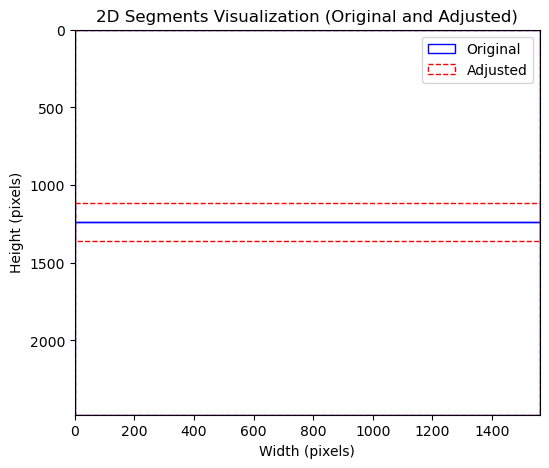

In [20]:
image_shape = (2478, 1560)
visualize_segments(main_coords, adjusted_main, image_shape)

In [21]:
adjusted_main

[(0, 1362, 0, 1560), (1116, 2478, 0, 1560)]

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import tifffile as tiff

# Load the 2D image
image = original_image


# Process each crop
cropped_images = []
for i, (h_start, h_end, w_start, w_end) in enumerate(adjusted_main):
    print(f"Cropping section {i}...")
    cropped = image[h_start:h_end, w_start:w_end]
    cropped_images.append(cropped)
    # Save each cropped section
    tiff.imwrite(f'output/test/2D_patch_test_{i}.tif', cropped)

print(f"{len(cropped_images)} cropped images saved successfully.")


Cropping section 0...
Cropping section 1...
2 cropped images saved successfully.
